#  Prädiktion der Bauteilqualität aus Prozessgrößenfeatures

Ziel ist es ein statisches polynomiales Modell zu bestimmen, welches die eingestellen Maschinenparameter auf die resultierende Bauteilqualität abbildet. 

Die für das Modelltraining (Schätzung der Modellparameter) und die Modellvalidierung zu verwendenden Daten wurden im Rahmen eines umfangreichen Versuchsplanes erhoben. Der Trainingsdatensatz umfasst die Daten von 2105 Produktionszyklen, der Validierungsdatensatz umfasst die Daten von 548 Produktionszyklen

In [1]:
import casadi as cs
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
data_train = pkl.load(open('feat_data_train.pkl','rb'))
data_val= pkl.load(open('feat_data_val.pkl','rb'))

Plotte Ausgangsgröße (Bauteilqualität) des Trainings- und Validierungsdatensatzes

(1.0, 40.0)

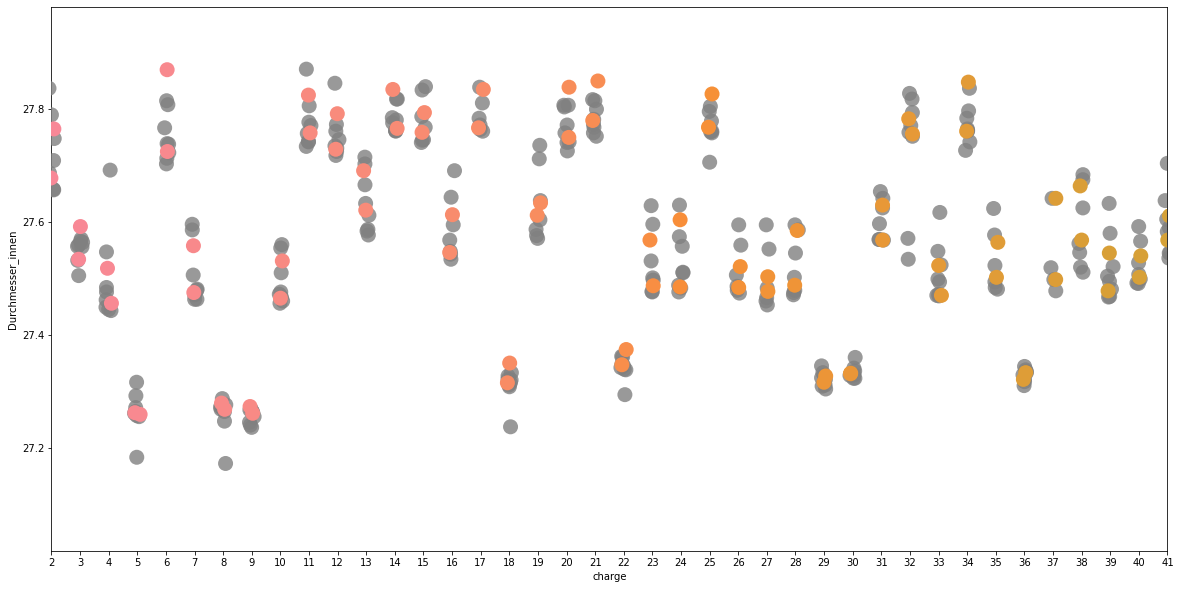

In [3]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.stripplot(x=data_train['charge'],y=data_train['Durchmesser_innen'],color='grey',alpha=.8,size=15,ax=ax)
sns.stripplot(x=data_val['charge'],y=data_val['Durchmesser_innen'],size=15,ax=ax)
ax.set_xlim([1,40]) # Zeige nur Teil des Plots da man sonst nicht viel erkennen kann 

Definiere zu identifizierendes Modell as CasADi-Funktion

In [4]:
W_h = cs.MX.sym('W_h',1,8)
b_h = cs.MX.sym('b_h',1,1)

W_o = theta1 = cs.MX.sym('W_o',1,1)
b_o = cs.MX.sym('b_o',1,1)


theta = cs.vcat([W_h.reshape((-1,1)),b_h,W_o.reshape((-1,1)),b_o])

u = cs.MX.sym('u',8,1)

h = cs.tanh(cs.mtimes(W_h,u)+b_h)
y = cs.mtimes(W_o,h)+b_o



f_model = cs.Function('f_model',[u,theta],[y],['u','theta'],['y'])

Werte Modell auf den Trainingsdaten aus und baue die Kostenfunktion auf

In [5]:
L = 0

u_label=['T_wkz_0', 'T_wkz_max', 't_Twkz_max', 'T_wkz_int', 'p_wkz_max','p_wkz_int', 'p_wkz_res', 't_pwkz_max']

y_label = ['Durchmesser_innen']

for k in data_train.index:
    u_k = data_train.loc[k][u_label].values.reshape((8,))
    
    y_k = data_train.loc[k][y_label]
    
    y_hat = f_model(u=u_k, theta=theta)['y']
    L = L + 0.5*(y_hat - y_k)**2

Initialisiere Struktur des Optimierungsproblems

In [7]:
nlp = {'x':theta, 'f':L}
S = cs.nlpsol('S', 'ipopt', nlp)

theta_init = np.random.normal(0,1,(11,1))

r=S(x0=theta_init)

theta_opt = r['x']


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       66

Total number of variables............................:       11
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

Werte das trainierte Modell auf den Trainingsdaten aus

In [8]:
y_hat = []

for k in data_train.index:
    u_k = data_train.loc[k][u_label].values.reshape((8,1))
    
    y_k = data_train.loc[k][y_label]
    
    y_hat.append(float(f_model(u=u_k, theta=theta_opt)['y']))
    
data_train = data_train.assign(y_hat=y_hat)

In [9]:
Werte das trainierte Modell auf den Validierungsdaten aus

SyntaxError: invalid syntax (3307483621.py, line 1)

In [13]:
y_hat = []

for k in data_val.index:
    u_k = data_val.loc[k][u_label].values.reshape((8,1))
    
    y_k = data_val.loc[k][y_label]
    
    y_hat.append(float(f_model(u=u_k, theta=theta_opt)['y']))
    
data_val = data_val.assign(y_hat=y_hat)

Plotte wahre und prädizierte Bauteilqualität auf dem Trainingsdatensatz

(1.0, 5.0)

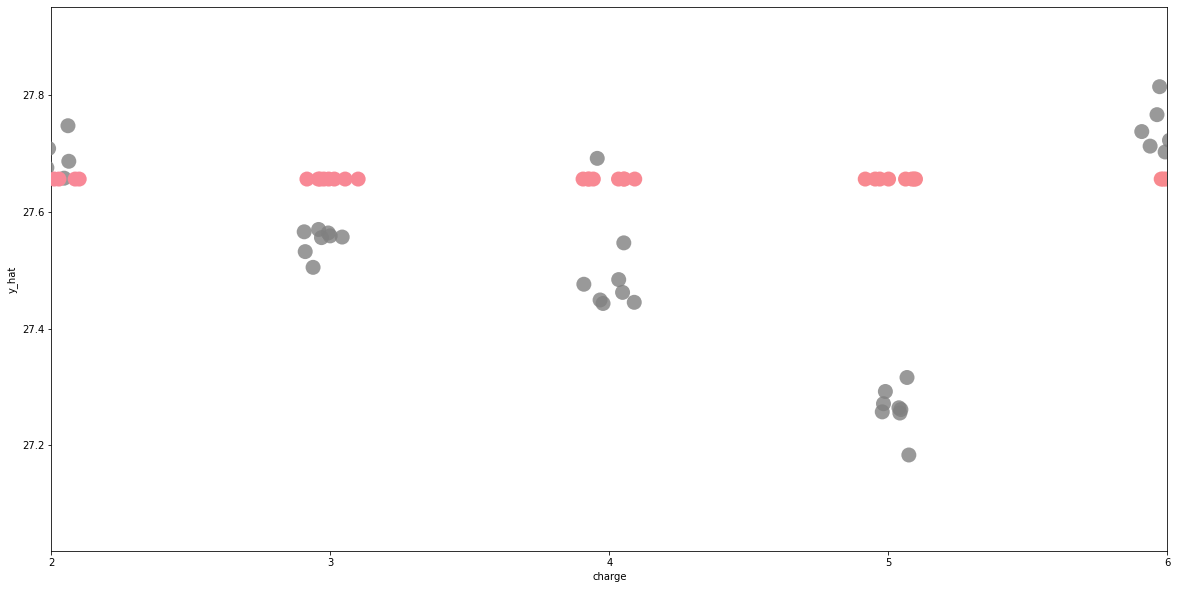

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.stripplot(x=data_train['charge'],y=data_train['Durchmesser_innen'],color='grey',alpha=.8,size=15,ax=ax)
sns.stripplot(x=data_train['charge'],y=data_train['y_hat'],size=15,ax=ax)
ax.set_xlim([1,5]) # Zeige nur Teil des Plots da man sonst nicht viel erkennen kann

In [11]:
Plotte wahre und prädizierte Bauteilqualität auf dem Trainingsdatensatz

SyntaxError: invalid syntax (1313062614.py, line 1)

(1.0, 10.0)

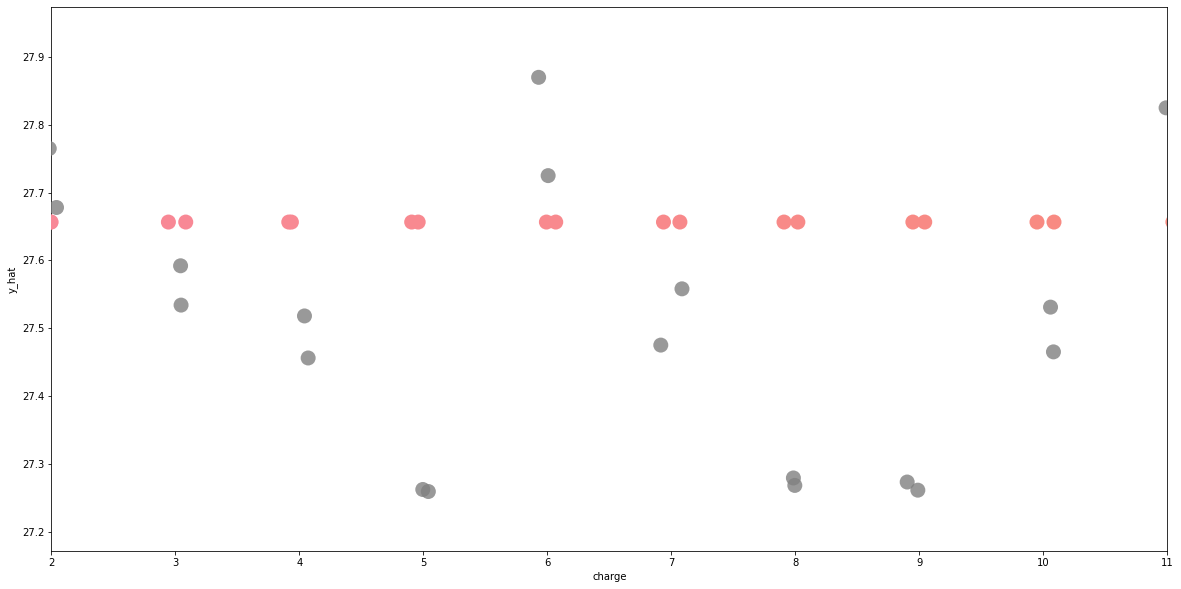

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.stripplot(x=data_val['charge'],y=data_val['Durchmesser_innen'],color='grey',alpha=.8,size=15,ax=ax)
sns.stripplot(x=data_val['charge'],y=data_val['y_hat'],size=15,ax=ax)
ax.set_xlim([1,10]) # Zeige nur Teil des Plots da man sonst nicht viel erkennen kann

Keine guten Ergebnisse, da Daten nicht normiert sind.

In [17]:
norm_min = data_train.min()
norm_max = data_train.max()

data_train = (data_train-norm_min)/(norm_max-norm_min) - 1
data_val = (data_val-norm_min)/(norm_max-norm_min) - 1

In [18]:
L = 0

u_label=['T_wkz_0', 'T_wkz_max', 't_Twkz_max', 'T_wkz_int', 'p_wkz_max','p_wkz_int', 'p_wkz_res', 't_pwkz_max']

y_label = ['Durchmesser_innen']

for k in data_train.index:
    u_k = data_train.loc[k][u_label].values.reshape((8,))
    
    y_k = data_train.loc[k][y_label]
    
    y_hat = f_model(u=u_k, theta=theta)['y']
    L = L + 0.5*(y_hat - y_k)**2

In [19]:
nlp = {'x':theta, 'f':L}
S = cs.nlpsol('S', 'ipopt', nlp)

theta_init = np.random.normal(0,1,(11,1))

r=S(x0=theta_init)

theta_opt = r['x']

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       66

Total number of variables............................:       11
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [20]:
y_hat = []

for k in data_train.index:
    u_k = data_train.loc[k][u_label].values.reshape((8,1))
    
    y_k = data_train.loc[k][y_label]
    
    y_hat.append(float(f_model(u=u_k, theta=theta_opt)['y']))
    
data_train = data_train.assign(y_hat=y_hat)

In [21]:
y_hat = []

for k in data_val.index:
    u_k = data_val.loc[k][u_label].values.reshape((8,1))
    
    y_k = data_val.loc[k][y_label]
    
    y_hat.append(float(f_model(u=u_k, theta=theta_opt)['y']))
    
data_val = data_val.assign(y_hat=y_hat)

(1.0, 5.0)

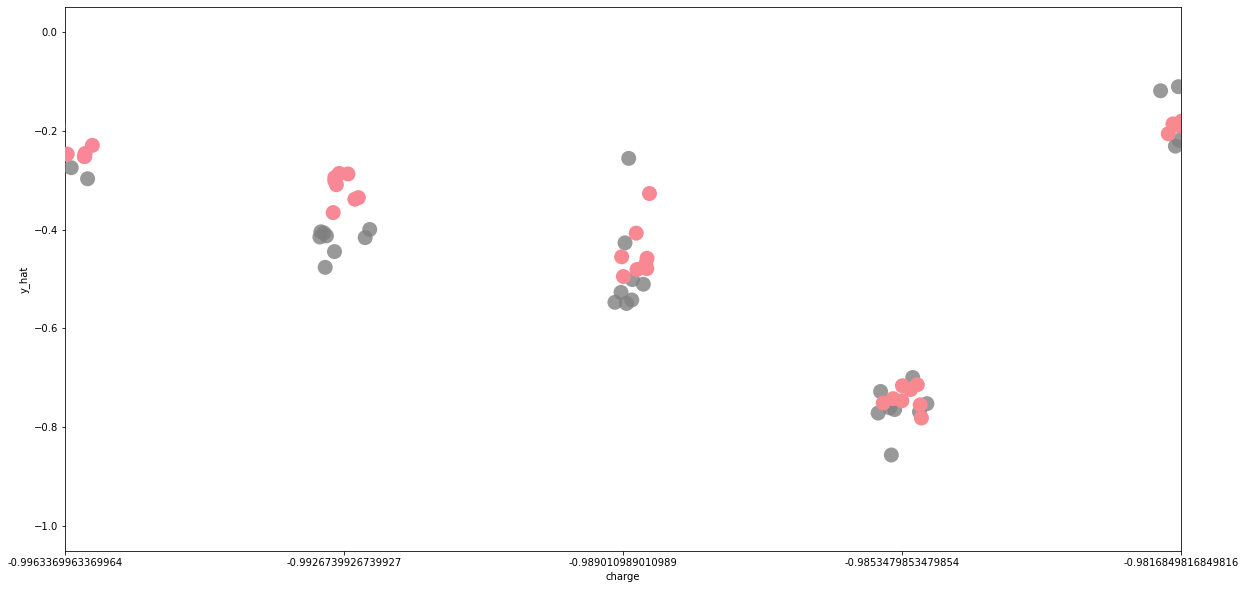

In [22]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.stripplot(x=data_train['charge'],y=data_train['Durchmesser_innen'],color='grey',alpha=.8,size=15,ax=ax)
sns.stripplot(x=data_train['charge'],y=data_train['y_hat'],size=15,ax=ax)
ax.set_xlim([1,5]) # Zeige nur Teil des Plots da man sonst nicht viel erkennen kann

(1.0, 10.0)

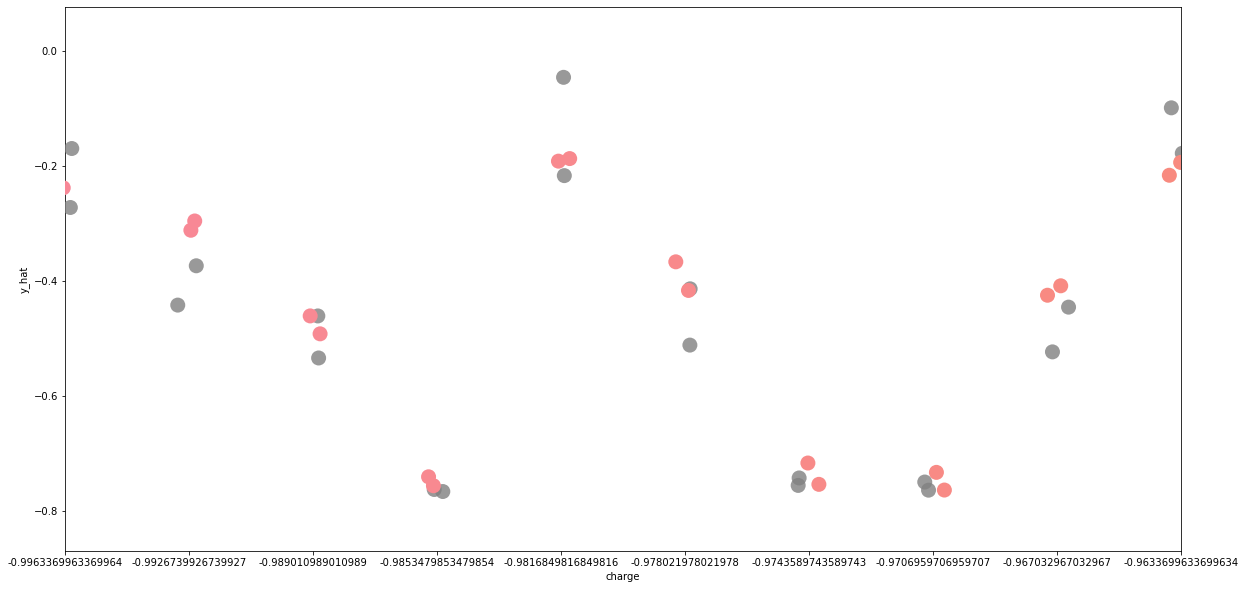

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.stripplot(x=data_val['charge'],y=data_val['Durchmesser_innen'],color='grey',alpha=.8,size=15,ax=ax)
sns.stripplot(x=data_val['charge'],y=data_val['y_hat'],size=15,ax=ax)
ax.set_xlim([1,10]) # Zeige nur Teil des Plots da man sonst nicht viel erkennen kann